In [9]:

# Annotations :
from typing import List, Dict, Callable, NoReturn, Any, Optional, Union

# Data and numerical :
import numpy as np
import pandas as pd
import scipy

# Plotting :
import matplotlib.pyplot as plt
import seaborn as sns


# Debugging only, remove after building : 
from preproc import import_csv
%matplotlib inline
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (15, 8)

In [11]:
def comparative_hba1c_plot(
    df: pd.core.frame.DataFrame,
    colum_name: str = "Sensor Glucose (mg/dL)",
    hba1c: Callable = lambda x: (x + 105) / 36.5,
    windows: Dict[str,int] = {
        "weekly": 7,
        "monthly": 30
    },
    kind: str = "mean"
) -> NoReturn:
    """ 
        Plot univariate statistics of a datetime-indexed glycaemic series.
        This is particularly assessing the glycaemic control of a patient.
        
        Most literature refers to glycated haemoglobin and various 
        formulas to obtain it from glycaemic averages. 
        
        # parameters:
        
                 df : Pandas dataframe, containing an arbitrary amount of columns.
                    
        column_name : String with the name of the column to be used.
                    
              hba1c : Callable, any function taking one parameter, preferably
                      mapping from glycaemia (mg/dL) to glycated haemoglobin.
                      
                      # IMPORTANT:
                          If your data is in mmol/L you MUST change the formula 
                          as the default one is for readings in mg/dL.
                    
            windows : Dictionary containing names and window sizes for rolling averages.
                      The values of the dictionary, given that the groupby is done 
                      by day (datetime) by default, the integers passed will be the number
                      of days to compute the moving averages.
                      
               kind : One of the following statistics:
                       "mean", "std", "var", or "median"
    """
    
    glc_to_hba1c = lambda x: (x + 105) / 36.5
    hba1c_to_glc = lambda x: x*36.5 - 105 
    valid_kinds = ["mean", "std", "var", "median"]
    
    if kind in valid_kinds:
        # Group by date, i.e. day of the year, keeping a reasonable x axis. 
        _statistic = df.groupby(df.index.date)[colum_name].apply(eval(f"pd.Series.{kind}"))
    else:
        raise Exception(f"kind should be one of {valid_kinds}")
    
    # Plot the main series :
    _statistic.apply(hba1c).plot(**{"label":"daily"})
                
    # Plot the moving averages :
    for key, value in windows.items():
        ax = _statistic.rolling(value).mean().apply(hba1c).plot(**{"label":key})
    
    ax.set_ylabel("HbA1c %")
    mean_hba1c = glc_to_hba1c(eval(f"df[colum_name].{kind}()"))
    secax = ax.secondary_yaxis('right', functions=(hba1c_to_glc, glc_to_hba1c))
    secax.set_ylabel('mg/dL')
    plt.axhline(mean_hba1c, **{"label": f"mean = {round(mean_hba1c,1)}", "c": "blue"})
    plt.legend()
    plt.title(f"Average {kind} of {colum_name}")
##

In [3]:
def proportions_visualiser(
    df: pd.core.frame.DataFrame,
    colum_name: str = "Sensor Glucose (mg/dL)",
    limits: Dict[str,int] = {
        "low": 70,
        "high": 180
    },
    windows: Dict[str,int] = {
        "weekly": 7,
        "monthly": 30
    },
    kind: str = "TIR"
) -> NoReturn:
    """
        A fundamental metric to assess glycaemic control whilst using CGM
        is TIR (Time in Range).
        
        This basically enounces the amount of time passed within a range, 
        which would be the objective of glycaemic control.
        
        This function enables visualisation of other metrics, see parameter `kind`
        for futher detail.
        
        # parameters:
        
                 df : Pandas dataframe, containing an arbitrary amount of columns.
                    
        column_name : String with the name of the column to be used.
                    
             limits : Dictionary containing the upper and lower boundaries for the range.
                      The keys MUST be "low" and "high".
                    
            windows : Dictionary containing names and window sizes for rolling averages.
                      The values of the dictionary, given that the groupby is done 
                      by day (datetime) by default, the integers passed will be the number
                      of days to compute the moving averages.
                       
               kind : One of the following three: 
                        TIR: Time In Range [low, high),
                        TAR: Time Above Range >= high,
                        TBR: Time Below Range < low
    """
    
    valid_kinds = ["TIR", "TBR", "TAR"]
    
    if "low" not in limits.keys() or "high" not in limits.keys():
        raise Exception(f"limits.keys() should be ['low', 'high'] not {limits.keys()}")
    
    titles = {
        "TIR": f"Time In Range [{limits['low']},{limits['high']})",
        "TAR": f"Time Above Range >= {limits['high']}",
        "TBR": f"Time Below Range < {limits['low']}"
    }
    
    kind = kind.upper()
    if kind not in valid_kinds:
        raise Exception(f"Invalid kind `{kind}`, select one from {valid_kinds} or refer to help({self.__name__})")
    
    TIR = lambda y: 100 * y[ (y >= limits["low"]) & (y < limits["high"]) ].count() / y.count()
    TBR = lambda y: 100 * y[ (y < limits["low"]) ].count() / y.count()
    TAR = lambda y: 100 * y[ (y >= limits["high"]) ].count() / y.count()
    
    _proportions = df[colum_name].groupby(df.index.date).apply(eval(f"{kind}"))
    
    _proportions.plot(**{"label": "daily"})
    
    for key, value in windows.items():
        _ax = _proportions.rolling(value).mean().plot(**{"label":key})
    
    _mean_proportion = _proportions.mean()
    plt.ylabel("Percentage")
    plt.axhline(_mean_proportion, **{"label": f"mean = {round(_mean_proportion,1)}", "c": "blue"})
    plt.legend()
    plt.title(titles[kind])
##    

In [26]:
def glycaemic_variability(
    df: pd.core.frame.DataFrame,
    colum_name: str = "Sensor Glucose (mg/dL)",
    windows: Dict[str,int] = {
        "weekly": 7,
        "monthly": 30
    },
    kind: str = "NAIVE"
) -> NoReturn:
    """
    
    """
    
    methods = {
        "NAIVE": lambda x: 100 * pd.Series.std(x) / pd.Series.mean(x)
    }
    
    kind = kind.upper()
    
    if kind in methods.keys():
        _statistic = df.groupby(df.index.date)[colum_name].apply(methods[kind])
    
    # Plot the main series :
    _statistic.plot(**{"label":"daily"})
    
    # Plot the moving averages :
    for key, value in windows.items():
        ax = _statistic.rolling(value).mean().plot(**{"label":key})
        
    _global_mean = _statistic.mean()
    plt.axhline(_global_mean, **{"label": f"mean = {round(_global_mean,1)}", "c": "blue"})
    plt.legend()
    plt.title(f"Glycaemic Variability, assesment method : {kind}")
##

In [4]:
def dist_plot(series: pd.core.series.Series, dropna: bool = True) -> NoReturn:
    """
        Given a pandas Series, generate a descriptive visualisation 
        with a boxplot and a histogram with a kde.
        By default, this function drops `nan` values. If you desire to
        handle them differently, you should do so beforehand and/or
        specify dropna=False.
    """
    
    if dropna:
        series = series.dropna()
    
    quarts = scipy.stats.mstats.mquantiles(series, [0.001, 0.25, 0.5, 0.75, 0.975])
    
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.25, .75)})
    sns.boxplot(series, ax=ax_box)
    sns.stripplot(series, color="orange", jitter=0.2, size=2.5, ax=ax_box)
    sns.distplot(series, ax=ax_hist, kde=True)
    ax_hist.axvline(series.mean())
    ax_hist.set_xticks(quarts)
    #ax_box.set(xlabel=f'Mean value : {int(series.mean())}')
    plt.title(f"Glycaemic Distribution μ = {int(series.mean())}, σ = {int(series.std())}")
##

In [5]:
#data = import_csv("preprocessed/CareLink-19-apr-2020-3-months.csv")

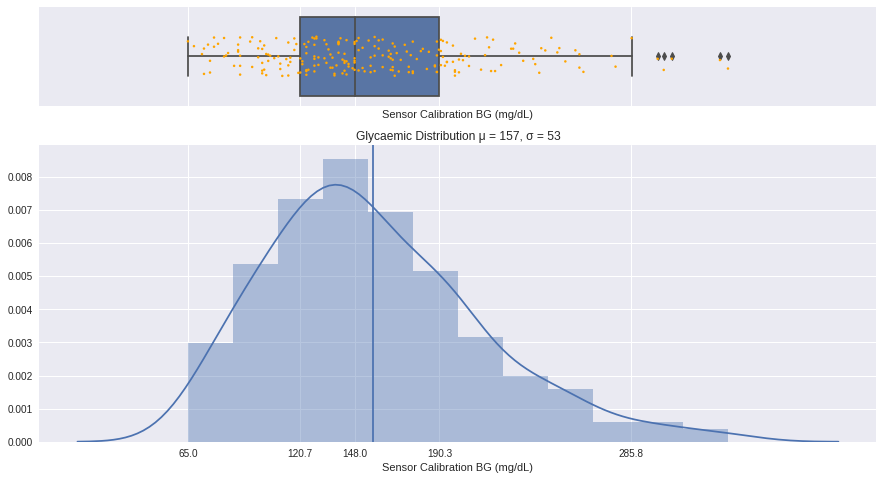

In [6]:
#dist_plot(data["Sensor Calibration BG (mg/dL)"])

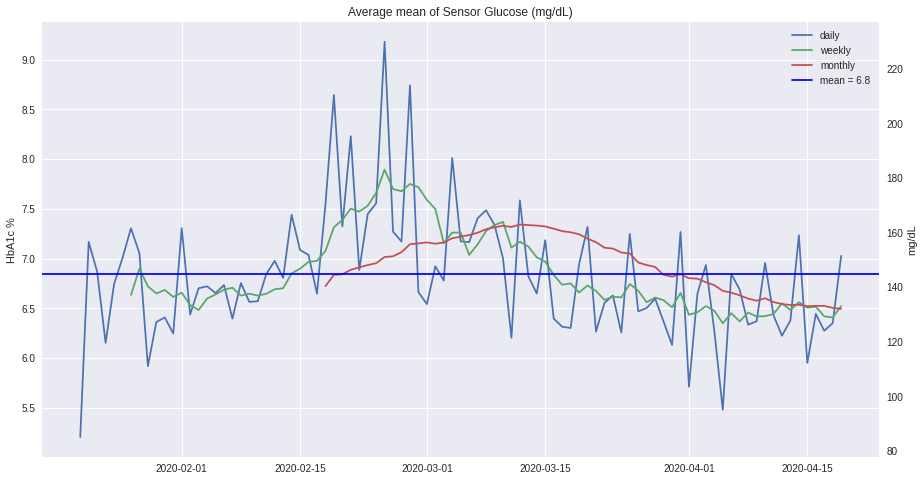

In [30]:
#comparative_hba1c_plot(data, kind="mean")

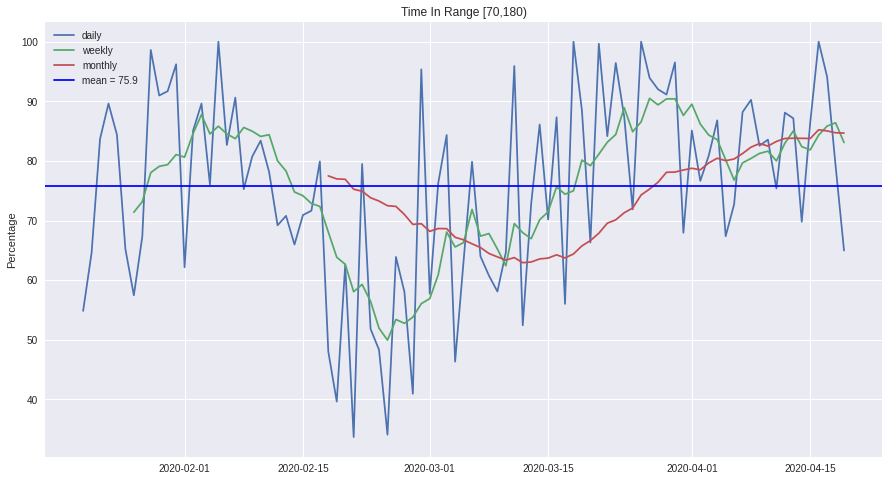

In [16]:
#proportions_visualiser(data)

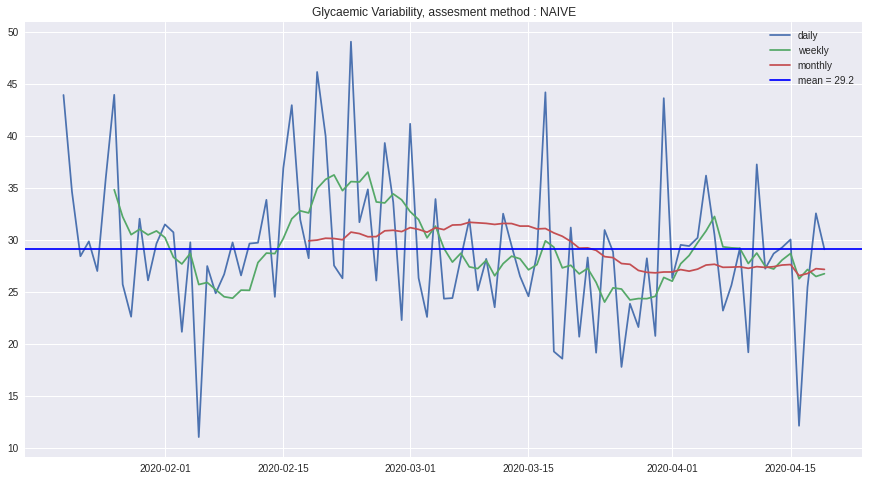

In [27]:
#glycaemic_variability(data)